In [5]:
# Paco Park sustainability analysis script
# Run in Jupyter notebook cell(s). Save as .py if you prefer.
# Author: Research Assistant (generated)
# Date: 2025-11-03

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pingouin as pg  # for robust ANOVA, post-hoc and Cronbach's alpha
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 0. CONFIG / PATHS
# ---------------------------
INPUT_XLSX = "dataset.xlsx"  # update filename if necessary
OUTPUT_DIR = "results_paco"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------------------
# 1. READ DATA
# ---------------------------
# Read first sheet; ensure pandas can read file. Requires openpyxl for .xlsx.
df_raw = pd.read_excel(INPUT_XLSX, engine="openpyxl")
df = df_raw.copy()
print(f"Read {df.shape[0]} rows and {df.shape[1]} columns")

# ---------------------------
# 2. QUICK CLEANING HELPERS
# ---------------------------
def extract_likert(x):
    """
    Extract the leading digit from strings like "4 - Often Encountered"
    If numeric already, return as int/float. Missing or unparsable -> NaN.
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return x
    s = str(x).strip()
    # look for leading digit 1-5
    m = re.search(r'([1-5])', s)
    if m:
        return int(m.group(1))
    # fallback: try convert fully
    try:
        return float(s)
    except:
        return np.nan

# Apply to all columns that are Likert items.
# We'll detect candidate columns by finding those that contain certain keywords or by position.
# But to be safe, we'll attempt to map all columns except demographic ones.
demographic_cols = [
    "Timestamp", "Name (Optional):", "Age:", "Sex:", "I. Respondent Affiliation",
    "II. How often do you visit Paco Park?", "III. Purpose of visit:", "Email Address"
]
# If actual column names differ slightly, try to detect them
demographic_cols = [c for c in df.columns if any(k in c for k in ["Timestamp","Name","Age","Sex","Respondent Affiliation","How often","Purpose","Email"])]

# Candidate item columns: everything except demographics
item_cols = [c for c in df.columns if c not in demographic_cols]
print(f"Detected {len(item_cols)} candidate item columns (first 10): {item_cols[:10]}")

# Convert Likert-like columns to numeric (extract leading digit)
for c in item_cols:
    df[c + "_num"] = df[c].apply(extract_likert)

# Use numeric columns list
num_cols = [c for c in df.columns if c.endswith("_num")]
print(f"Numeric columns created: {len(num_cols)}")

# ---------------------------
# 3. DOMAIN MAPPING (adjust as needed)
# ---------------------------
# Map actual column text to domain item names — adjust if necessary
# Infer names by matching substrings (safer than hardcoding exact strings)
col_map = {c: c for c in df.columns}  # identity map initially

# We'll create domain lists by searching the original column texts for keywords.
# These heuristics may need manual tuning.

original_cols = [c for c in df_raw.columns]

# Define heuristics for each domain: list of substrings to match
env_keywords = [
    "natural environment", "Maintenance efforts", "Proper waste segregation", "Challenges brought by urbanization", "clean", "waste management", "cleanliness"
]
cult_keywords = [
    "Traditional", "cultural events", "heritage", "restoration", "preservation", "cultural heritage", "identity", "appreciation", "restoration efforts"
]
visit_keywords = [
    "Visitor facilities", "paths", "walkways", "access for wheelchairs", "Visitor pathways", "Security personnel", "public transportation", "accessible", "visitors actively follow", "facilities"
]
comm_keywords = [
    "Local communities", "Local businesses", "Residents around Paco Park benefit", "Social media advocacy", "Local religious", "Local stakeholders", "involvement", "collaborate", "stakeholders"
]

# helper to find columns containing any keyword
def find_cols_by_keywords(keywords, cols):
    found = []
    for kw in keywords:
        for c in cols:
            if kw.lower() in str(c).lower() and c not in found:
                found.append(c)
    return found

env_items = find_cols_by_keywords(env_keywords, original_cols)
cult_items = find_cols_by_keywords(cult_keywords, original_cols)
visit_items = find_cols_by_keywords(visit_keywords, original_cols)
comm_items = find_cols_by_keywords(comm_keywords, original_cols)

print("ENV items:", env_items)
print("CULT items:", cult_items)
print("VISIT items:", visit_items)
print("COMM items:", comm_items)

# If lists are empty or missing items, you may want to manually set them below;
# You can uncomment and edit these lists if the automatic detection misses items.
# Example:
# env_items = ["The park's natural environment is consistently well-maintained", ...]


# Convert those to numeric column names (append "_num")
env_num = [c + "_num" for c in env_items if c + "_num" in df.columns]
cult_num = [c + "_num" for c in cult_items if c + "_num" in df.columns]
visit_num = [c + "_num" for c in visit_items if c + "_num" in df.columns]
comm_num = [c + "_num" for c in comm_items if c + "_num" in df.columns]

print("ENV numeric cols:", env_num)
print("CULT numeric cols:", cult_num)
print("VISIT numeric cols:", visit_num)
print("COMM numeric cols:", comm_num)

# ---------------------------
# 4. COMPUTE DOMAIN SCORES (mean per participant)
# ---------------------------
def compute_domain_mean(df, cols, domain_name):
    if len(cols) == 0:
        df[domain_name + "_mean"] = np.nan
        return
    df[domain_name + "_mean"] = df[cols].mean(axis=1, skipna=True)

compute_domain_mean(df, env_num, "Environmental")
compute_domain_mean(df, cult_num, "Cultural")
compute_domain_mean(df, visit_num, "VisitorMgmt")
compute_domain_mean(df, comm_num, "Community")

domain_cols = ["Environmental_mean", "Cultural_mean", "VisitorMgmt_mean", "Community_mean"]
print("Domain columns:", domain_cols)

# Save domain-level dataframe
domains_df = df[demographic_cols + domain_cols].copy()
domains_df.to_csv(os.path.join(OUTPUT_DIR, "domain_scores.csv"), index=False)
print("Saved domain scores to", os.path.join(OUTPUT_DIR, "domain_scores.csv"))

# ---------------------------
# 5. RELIABILITY (Cronbach's alpha) for each domain
# ---------------------------
def cronbach_alpha(items_df):
    # items_df: DataFrame of numeric item columns for the scale
    items_df = items_df.dropna(axis=0, how='all')  # drop rows all NaN
    itemvars = items_df.var(axis=0, ddof=1)
    totalvar = items_df.sum(axis=1).var(ddof=1)
    n_items = items_df.shape[1]
    if n_items <= 1:
        return np.nan
    alpha = (n_items / (n_items - 1)) * (1 - itemvars.sum() / totalvar)
    return alpha

reliability = {}
if len(env_num) > 0:
    reliability['Environmental'] = cronbach_alpha(df[env_num])
if len(cult_num) > 0:
    reliability['Cultural'] = cronbach_alpha(df[cult_num])
if len(visit_num) > 0:
    reliability['VisitorMgmt'] = cronbach_alpha(df[visit_num])
if len(comm_num) > 0:
    reliability['Community'] = cronbach_alpha(df[comm_num])

print("Cronbach's alpha per domain:", reliability)

# Use pingouin for item-level alpha if installed (gives alpha and CI)
# Example: pg.cronbach_alpha(data=df[env_num].dropna())
# Save reliability to CSV
pd.Series(reliability).to_csv(os.path.join(OUTPUT_DIR, "cronbach_alpha_by_domain.csv"))

# ---------------------------
# 6. DESCRIPTIVE STATISTICS & VISUALIZATION
# ---------------------------
desc = domains_df[domain_cols].describe().transpose()
desc['median'] = domains_df[domain_cols].median()
desc.to_csv(os.path.join(OUTPUT_DIR, "domain_descriptives.csv"))
print("Saved descriptive stats to", os.path.join(OUTPUT_DIR, "domain_descriptives.csv"))
print(desc)

# Boxplots by domain
plt.figure(figsize=(8,6))
sns.boxplot(data=domains_df[domain_cols], orient="v")
plt.title("Domain score distributions")
plt.ylabel("Mean Likert score (1-5)")
plt.savefig(os.path.join(OUTPUT_DIR, "boxplot_domains.png"), dpi=200)
plt.close()

# Histograms
for col in domain_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(domains_df[col].dropna(), kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel("Mean score (1-5)")
    plt.savefig(os.path.join(OUTPUT_DIR, f"hist_{col}.png"), dpi=200)
    plt.close()

# ---------------------------
# 7. GROUP COMPARISON: Are there differences among respondent affiliations?
# ---------------------------
# Prepare group variable
group_col_candidates = [c for c in df.columns if "Respondent Affiliation" in c or "Affiliation" in c]
if len(group_col_candidates) == 0:
    # try some fuzzy matches
    group_col_candidates = [c for c in df.columns if 'Affiliation' in str(c) or 'Respondent' in str(c)]
group_col = group_col_candidates[0] if len(group_col_candidates) > 0 else None
print("Using group column:", group_col)

# Clean group column values and drop NaNs
if group_col:
    df['group'] = df[group_col].astype(str).str.strip()
else:
    df['group'] = 'Unknown'

# Select rows with at least one domain present
analysis_df = df[['group'] + domain_cols].dropna(axis=0, how='all').copy()

# For each domain: check normality and homogeneity, then ANOVA or Kruskal
grouped_results = {}
for domain in domain_cols:
    # dropna for domain:
    data = analysis_df[['group', domain]].dropna()
    groups = data['group'].unique()
    print("\nDomain:", domain, "n_groups:", len(groups))
    # Normality per group (Shapiro-Wilk) if group size is small (<5000)
    normal_pvals = {}
    for g in groups:
        arr = data.loc[data['group']==g, domain].dropna()
        if arr.shape[0] >= 3 and arr.shape[0] <= 5000:
            try:
                stat, p = stats.shapiro(arr)
            except Exception:
                p = np.nan
            normal_pvals[g] = p
        else:
            normal_pvals[g] = np.nan
    print("Shapiro p-values per group (NaN if not tested):", normal_pvals)
    # Levene's test for homogeneity
    group_arrays = [data.loc[data['group']==g, domain].dropna().values for g in groups]
    try:
        lev_stat, lev_p = stats.levene(*group_arrays, center='median')
    except Exception as e:
        lev_p = np.nan
        lev_stat = np.nan
    print("Levene p:", lev_p)
    # Decide test:
    # If all group Shapiro p > 0.05 and Levene p > 0.05 -> one-way ANOVA
    normal_ok = all((p is np.nan) or (p > 0.05) for p in normal_pvals.values())
    homogeneity_ok = (lev_p is not np.nan) and (lev_p > 0.05)
    result = {}
    if normal_ok and homogeneity_ok:
        # ANOVA
        formula = f"{domain} ~ C(group)"
        model = ols(formula, data=data).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        result['test'] = 'ANOVA'
        result['aov_table'] = aov_table
        # Tukey HSD post-hoc
        try:
            tukey = pairwise_tukeyhsd(endog=data[domain], groups=data['group'], alpha=0.05)
            result['tukey'] = tukey
        except Exception as e:
            result['tukey'] = str(e)
    else:
        # Kruskal-Wallis
        try:
            kw_stat, kw_p = stats.kruskal(*group_arrays)
            result['test'] = 'Kruskal'
            result['kw_stat'] = kw_stat
            result['kw_p'] = kw_p
            # Dunn post-hoc using pingouin
            try:
                dunn = pg.pairwise_tests(dv=domain, between='group', data=data, padjust='bonf', parametric=False)
                result['dunn'] = dunn
            except Exception as e:
                result['dunn'] = str(e)
        except Exception as e:
            result['test'] = 'Error'
            result['error'] = str(e)
    grouped_results[domain] = result
    # Save each domain's summary to csv/text
    with open(os.path.join(OUTPUT_DIR, f"group_test_{domain}.txt"), "w", encoding="utf-8") as f:
        f.write("Domain: " + domain + "\n")
        f.write("Normality Shapiro p-values per group:\n")
        for k,v in normal_pvals.items():
            f.write(f"  {k}: {v}\n")
        f.write(f"Levene p: {lev_p}\n")
        f.write("Result:\n")
        f.write(str(result) + "\n")

print("Saved group test outputs to", OUTPUT_DIR)

# ---------------------------
# 8. EFFECT SIZE (eta-squared for ANOVA or epsilon-squared/omega for Kruskal)
# ---------------------------
# We'll calculate eta-squared for ANOVA results if present
effect_sizes = {}
for domain, res in grouped_results.items():
    if res.get('test') == 'ANOVA' and 'aov_table' in res:
        aov = res['aov_table']
        # eta squared = SSB / SST
        ss_between = aov.loc['C(group)', 'sum_sq'] if 'C(group)' in aov.index else aov.iloc[0]['sum_sq']
        ss_total = aov['sum_sq'].sum()
        eta2 = ss_between / ss_total if ss_total != 0 else np.nan
        effect_sizes[domain] = {'eta2': eta2}
    elif res.get('test') == 'Kruskal':
        # compute eta2 from H statistic approximation: eta2 = H/(N-1)
        H = res.get('kw_stat')
        N = df.shape[0]
        if H is not None:
            eta2 = H / (N - 1) if N > 1 else np.nan
            effect_sizes[domain] = {'eta2_approx': eta2}
        else:
            effect_sizes[domain] = {}
pd.DataFrame(effect_sizes).to_csv(os.path.join(OUTPUT_DIR, "effect_sizes.csv"))
print("Saved effect sizes to", os.path.join(OUTPUT_DIR, "effect_sizes.csv"))

# ---------------------------
# 9. PCA / Exploratory Factor Analysis on all item-level numeric variables
# ---------------------------
# We'll use numeric item columns (num_cols). Drop columns with all-NaN.
items_for_pca = [c for c in num_cols if df[c].notna().sum() > 0]
print("Items used for PCA:", len(items_for_pca))
items_df = df[items_for_pca].dropna(axis=0, how='any')  # keep only complete rows for PCA

if items_df.shape[0] >= 10 and items_df.shape[1] >= 2:
    scaler = StandardScaler()
    X = scaler.fit_transform(items_df)
    pca = PCA(n_components=min(items_df.shape[1], 10), random_state=RANDOM_SEED)
    pcs = pca.fit_transform(X)
    ev = pca.explained_variance_ratio_
    cumvar = np.cumsum(ev)
    pca_df = pd.DataFrame({
        'PC': [f"PC{i+1}" for i in range(len(ev))],
        'ExplainedVar': ev,
        'CumulativeVar': cumvar
    })
    pca_df.to_csv(os.path.join(OUTPUT_DIR, "pca_explained_variance.csv"), index=False)
    print(pca_df)
    # Component loadings
    loadings = pd.DataFrame(pca.components_.T, index=items_df.columns, columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])])
    loadings.to_csv(os.path.join(OUTPUT_DIR, "pca_loadings.csv"))
    # Scree plot
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(ev)+1), ev, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Scree Plot")
    plt.xticks(range(1, len(ev)+1))
    plt.savefig(os.path.join(OUTPUT_DIR, "pca_scree.png"), dpi=200)
    plt.close()
else:
    print("Not enough complete data for PCA. Skipping PCA step.")

# ---------------------------
# 10. RECOMMENDATION HELPER: identify top weaknesses (lowest mean items)
# ---------------------------
# Create item-level means
item_means = df[items_for_pca].mean().sort_values()
item_means.to_csv(os.path.join(OUTPUT_DIR, "item_means_sorted.csv"))
print("Saved item means to", os.path.join(OUTPUT_DIR, "item_means_sorted.csv"))

# Print lowest-scoring items (suggest focus areas)
lowest = item_means.head(10)
print("Lowest mean items (suggest priority for improvement):")
print(lowest)

# ---------------------------
# 11. SAVE CLEANED DATA (numeric)
# ---------------------------
clean_numeric_cols = demographic_cols + num_cols + domain_cols
# ensure columns exist
clean_numeric_cols = [c for c in clean_numeric_cols if c in df.columns]
df[clean_numeric_cols].to_excel(os.path.join(OUTPUT_DIR, "cleaned_numeric_data.xlsx"), index=False)
print("Saved cleaned numeric dataset to", os.path.join(OUTPUT_DIR, "cleaned_numeric_data.xlsx"))

# ---------------------------
# 12. SUMMARY REPORT (simple text)
# ---------------------------
report_lines = []
report_lines.append("Paco Park Sustainability Analysis - Summary\n")
report_lines.append(f"Total respondents: {df.shape[0]}\n")
report_lines.append("Cronbach's alpha per domain:\n")
for k,v in reliability.items():
    report_lines.append(f"  {k}: {v}\n")
report_lines.append("\nDomain descriptives (mean, std):\n")
for col in domain_cols:
    report_lines.append(f"  {col}: mean={domains_df[col].mean():.3f}, std={domains_df[col].std():.3f}\n")
report_lines.append("\nLowest-scoring items (priority for action):\n")
for item, val in lowest.items():
    report_lines.append(f"  {item}: mean={val:.3f}\n")

with open(os.path.join(OUTPUT_DIR, "summary_report.txt"), "w", encoding="utf-8") as f:
    f.writelines(report_lines)

print("Saved textual summary to", os.path.join(OUTPUT_DIR, "summary_report.txt"))

# ---------------------------
# 13. QUICK GUIDANCE ON INTERPRETING RESULTS (printed)
# ---------------------------
print("\n--- Quick guidance ---")
print("1) Check 'cronbach_alpha_by_domain.csv' to evaluate internal consistency for each domain.")
print("2) See 'domain_descriptives.csv' and 'item_means_sorted.csv' to identify strengths and weaknesses.")
print("3) Group comparisons (ANOVA/Kruskal) outputs are in the 'results_paco' folder (files named group_test_*).")
print("4) PCA files (if computed): 'pca_explained_variance.csv' and 'pca_loadings.csv'.")
print("5) Visuals saved as PNG files in the results directory.\n")

# End of script


Read 216 rows and 33 columns
Detected 25 candidate item columns (first 10): ["The park's natural environment is consistently well-maintained,", 'Maintenance efforts contribute to a clean and eco-friendly park environment', 'Opportunities for tourists, locals, and management to participate in sustaining Paco Park (e.g., rules enforcement, volunteerism, aware activities) are evident.', 'Proper waste segregation, cleanliness, and waste management practices are observed in Paco Park.', 'Challenges brought by urbanization (e.g., noise pollution, overcrowding) are being managed effectively inside Paco Park.', 'Traditional and cultural events (e.g. concerts, heritage tours, religious activities) are supported and conducted inside Paco Park.', 'The management ensures that urbanization pressures (e.g., modernization, commercialization) do not compromise the cultural heritage of Paco Park.', 'Visiting Paco Park gives me a deeper appreciation of Manila’s cultural heritage.', 'Restoration efforts 

✅ Loaded cleaned dataset with 216 rows and 37 columns

Detected domain columns: ['Environmental_mean', 'Cultural_mean', 'VisitorMgmt_mean', 'Community_mean']
Group variable: I. Respondent Affiliation 

📊 Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max,median
Environmental_mean,216.0,4.114815,0.614978,2.000000,3.600000,4.200000,4.600000,5.0,4.200000
Cultural_mean,216.0,3.551698,0.379415,2.166667,3.333333,3.666667,3.833333,4.5,3.666667
VisitorMgmt_mean,216.0,4.088889,0.696213,2.000000,3.600000,4.200000,4.600000,5.0,4.200000
Community_mean,216.0,3.984954,0.658954,2.000000,3.500000,4.000000,4.625000,5.0,4.000000


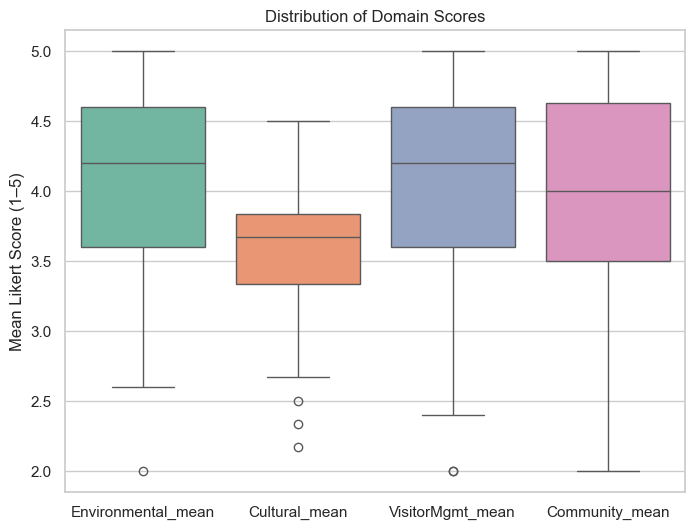

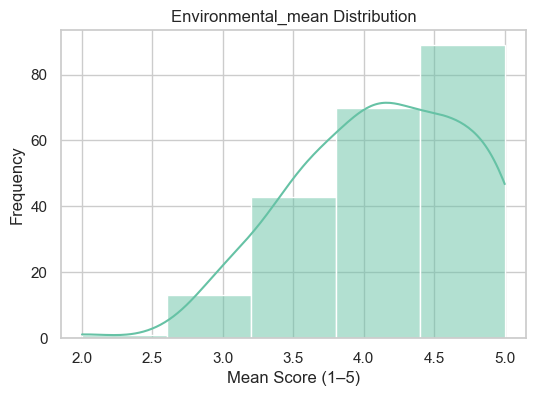

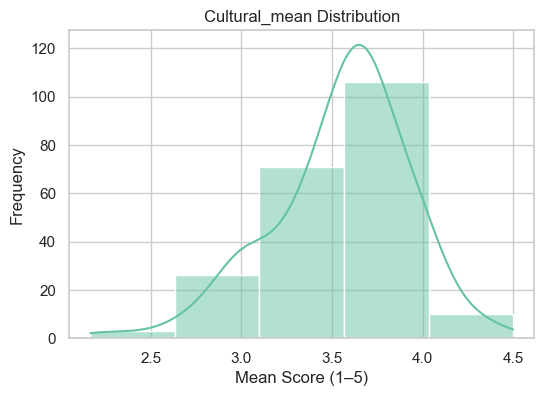

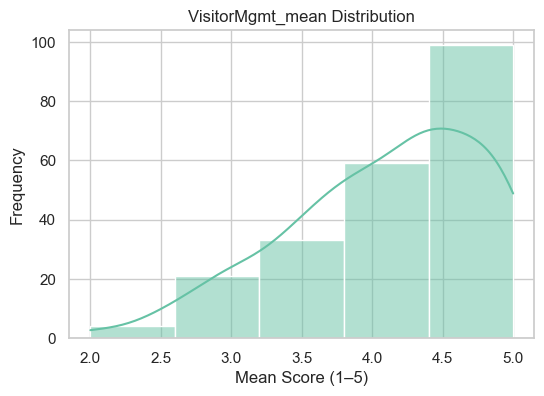

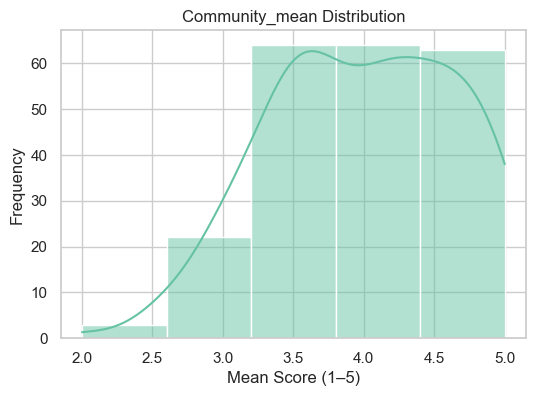


🧩 Reliability (Cronbach's Alpha):
  Environmental: Not enough items to compute α
  Cultural: Not enough items to compute α
  VisitorMgmt: Not enough items to compute α
  Community: Not enough items to compute α

👥 Group Comparisons by: I. Respondent Affiliation

--- Environmental_mean ---
Levene test p=0.0647
→ Using Kruskal-Wallis Test
Kruskal-Wallis H=8.019, p=0.0456


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,Local Visitor,Nearby Resident,False,True,-2.526563,97.411506,two-sided,0.013129,0.078777,bonf,3.362,-0.410960
1,group,Local Visitor,Park Personnel/Staff,False,True,-1.402776,34.823495,two-sided,0.169537,1.000000,bonf,0.549,-0.311426
2,group,Local Visitor,Tourist/Non-Local Tourist,False,True,0.410565,110.219489,two-sided,0.682189,1.000000,bonf,0.205,0.064862
3,group,Nearby Resident,Park Personnel/Staff,False,True,0.328907,39.378735,two-sided,0.743969,1.000000,bonf,0.273,0.088792
4,group,Nearby Resident,Tourist/Non-Local Tourist,False,True,2.760420,84.119570,two-sided,0.007085,0.042507,bonf,5.84,0.587674
5,group,Park Personnel/Staff,Tourist/Non-Local Tourist,False,True,1.629657,37.546416,two-sided,0.111536,0.669219,bonf,0.784,0.442292


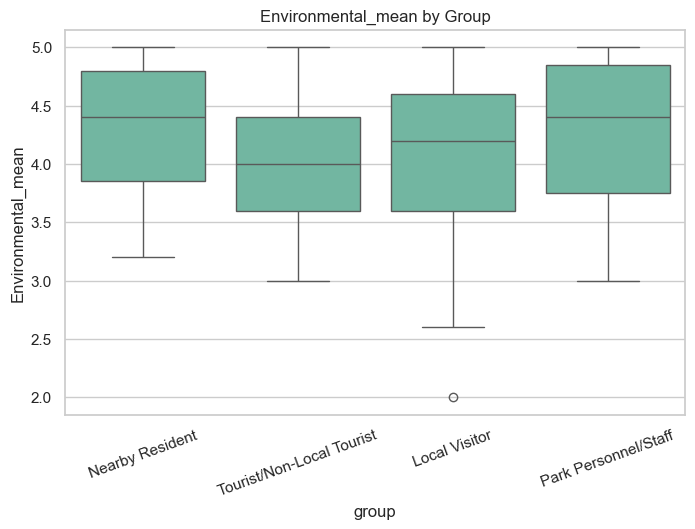


--- Cultural_mean ---
Levene test p=0.0092
→ Using Kruskal-Wallis Test
Kruskal-Wallis H=3.744, p=0.2904


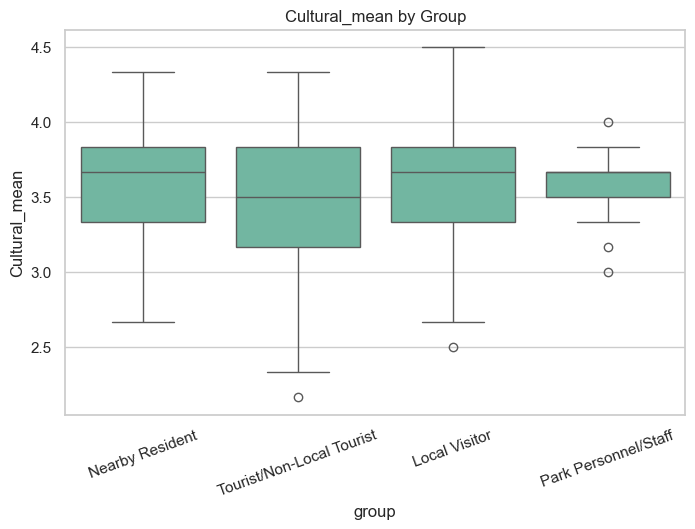


--- VisitorMgmt_mean ---
Levene test p=0.0090
→ Using Kruskal-Wallis Test
Kruskal-Wallis H=9.116, p=0.0278


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,Local Visitor,Nearby Resident,False,True,-2.701409,103.025307,two-sided,0.008075,0.048449,bonf,5.027,-0.429563
1,group,Local Visitor,Park Personnel/Staff,False,True,-2.130157,44.419592,two-sided,0.038734,0.232402,bonf,1.655,-0.397822
2,group,Local Visitor,Tourist/Non-Local Tourist,False,True,0.376752,98.947626,two-sided,0.707165,1.000000,bonf,0.203,0.062141
3,group,Nearby Resident,Park Personnel/Staff,False,True,0.098774,47.312533,two-sided,0.921735,1.000000,bonf,0.262,0.025097
4,group,Nearby Resident,Tourist/Non-Local Tourist,False,True,2.753525,84.631982,two-sided,0.007214,0.043286,bonf,5.748,0.582786
5,group,Park Personnel/Staff,Tourist/Non-Local Tourist,False,True,2.261976,52.158606,two-sided,0.027893,0.167357,bonf,2.154,0.545056


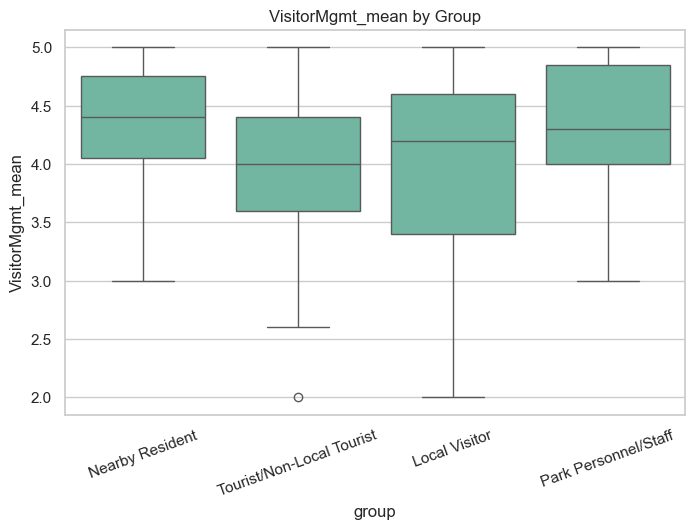


--- Community_mean ---
Levene test p=0.0901
→ Using Kruskal-Wallis Test
Kruskal-Wallis H=4.014, p=0.2600


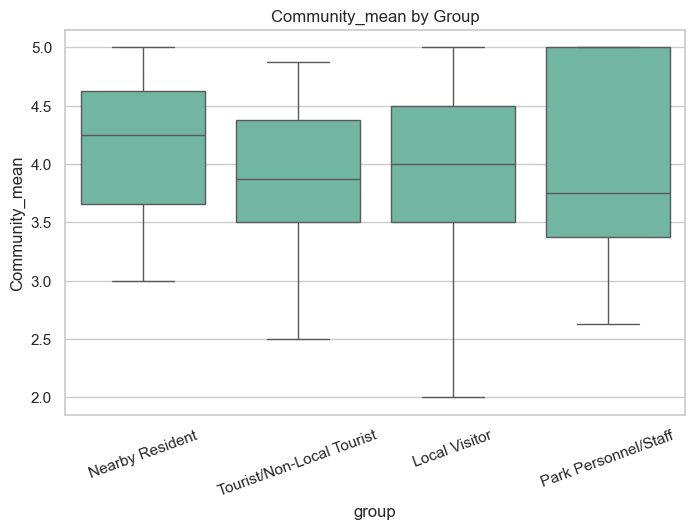

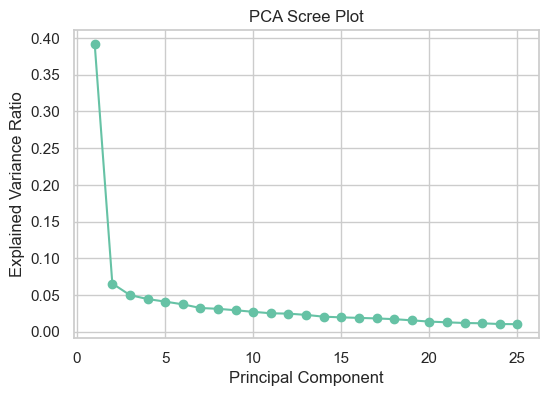


🔍 PCA Explained Variance (%):


,PC,ExplainedVariance%,Cumulative%
0,1,39.171535,39.171535
1,2,6.552810,45.724345
2,3,4.979598,50.703943
3,4,4.439757,55.143700
4,5,4.089079,59.232779
5,6,3.718103,62.950882
6,7,3.218965,66.169848
7,8,3.108281,69.278128
8,9,2.912587,72.190716
9,10,2.697659,74.888375



⚙️ Lowest-Scoring Items (Focus Areas):



,Mean Score
Visiting Paco Park gives me a deeper appreciation of Manila’s cultural heritage._num,2.287037
"The management ensures that urbanization pressures (e.g., modernization, commercialization) do not compromise the cultural heritage of Paco Park._num",2.666667
"Challenges brought by urbanization (e.g., noise pollution, overcrowding) are being managed effectively inside Paco Park._num",3.782407
Social media advocacy by community members effectively raises awareness about preserving Paco Park._num,3.837963
Local businesses collaborate with Paco Park management to promote sustainable tourism._num,3.865741
Local communities actively participate in programs related to Paco Park's sustainability._num,3.902778
"Restoration efforts are noticeable (e.g., repairs of old structures, repainting or reinforcement of heritage features)._num",3.912037
The paths or walkways including access for wheelchairs/strollers are evident._num,3.944444
"Residents around Paco Park benefit economically (e.g., jobs, livelihood, tourism-related businesses) from its tourism activities._num",3.949074
"Visitor pathways are well-marked to protect sensitive areas (e.g., gardens, historic structures)._num",4.009259


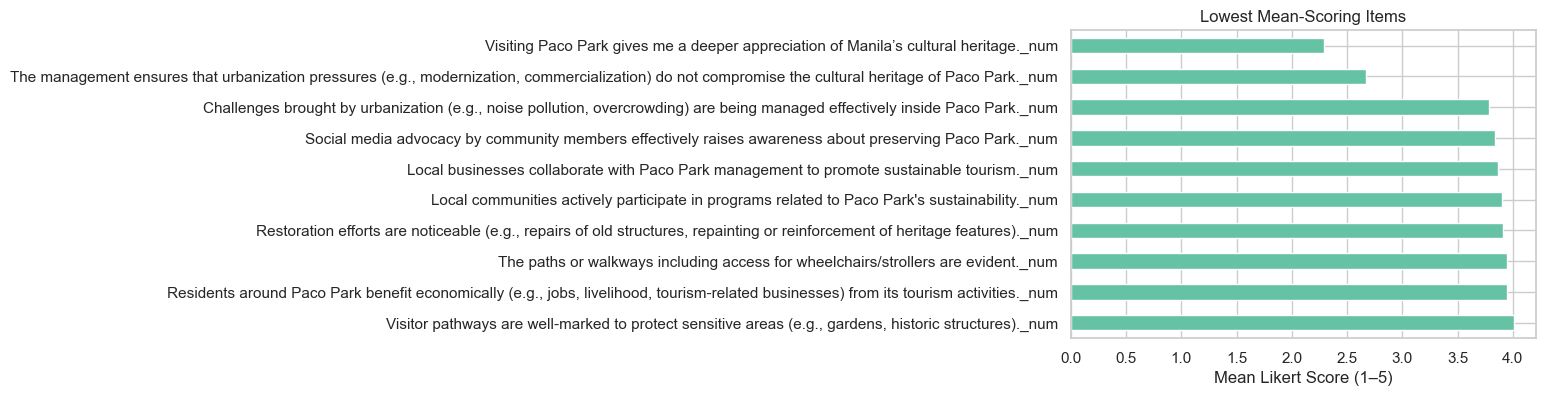


📘 Summary Insights:
  Environmental_mean: mean=4.11, std=0.61
  Cultural_mean: mean=3.55, std=0.38
  VisitorMgmt_mean: mean=4.09, std=0.70
  Community_mean: mean=3.98, std=0.66

✅ Analysis Complete.


In [7]:
# ==========================================================
# Paco Park Sustainability Data Analysis (Notebook Version)
# Using: cleaned_numeric_data.xlsx
# Displays all results and plots inline
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# 1. Load Cleaned Data
# ----------------------------------------------------------
df = pd.read_excel("cleaned_numeric_data.xlsx")
print(f"✅ Loaded cleaned dataset with {df.shape[0]} rows and {df.shape[1]} columns\n")

# Detect domain columns automatically
domain_cols = [c for c in df.columns if "_mean" in c]
group_col = [c for c in df.columns if "Affiliation" in c or "Respondent" in c]
group_col = group_col[0] if group_col else None
print("Detected domain columns:", domain_cols)
print("Group variable:", group_col, "\n")

# ----------------------------------------------------------
# 2. Descriptive Statistics
# ----------------------------------------------------------
desc = df[domain_cols].describe().T
desc["median"] = df[domain_cols].median()
print("📊 Descriptive Statistics:\n")
display(desc)

# ----------------------------------------------------------
# 3. Visualizations
# ----------------------------------------------------------
sns.set(style="whitegrid", palette="Set2")

# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=df[domain_cols])
plt.title("Distribution of Domain Scores")
plt.ylabel("Mean Likert Score (1–5)")
plt.show()

# Histograms for each domain
for col in domain_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=5)
    plt.title(f"{col} Distribution")
    plt.xlabel("Mean Score (1–5)")
    plt.ylabel("Frequency")
    plt.show()

# ----------------------------------------------------------
# 4. Reliability Analysis (Cronbach’s Alpha)
# ----------------------------------------------------------
def cronbach_alpha(data):
    items = data.dropna(axis=0, how="all")
    k = items.shape[1]
    if k < 2:
        return np.nan
    item_vars = items.var(axis=0, ddof=1)
    total_var = items.sum(axis=1).var(ddof=1)
    alpha = (k / (k - 1)) * (1 - item_vars.sum() / total_var)
    return alpha

print("\n🧩 Reliability (Cronbach's Alpha):")
for domain in domain_cols:
    # Extract item columns that belong to the domain
    base = domain.replace("_mean", "")
    item_cols = [c for c in df.columns if base in c and c.endswith("_num")]
    if len(item_cols) > 1:
        alpha = cronbach_alpha(df[item_cols])
        print(f"  {base}: α = {alpha:.3f}")
    else:
        print(f"  {base}: Not enough items to compute α")

# ----------------------------------------------------------
# 5. Group Comparison (ANOVA / Kruskal-Wallis)
# ----------------------------------------------------------
if group_col:
    df["group"] = df[group_col].astype(str).str.strip()
    print("\n👥 Group Comparisons by:", group_col)
    for domain in domain_cols:
        print(f"\n--- {domain} ---")
        data = df[[domain, "group"]].dropna()
        # Check assumptions
        groups = [g[domain].dropna().values for _, g in data.groupby("group")]
        lev_stat, lev_p = stats.levene(*groups)
        print(f"Levene test p={lev_p:.4f}")
        normal_ok = all(stats.shapiro(g)[1] > 0.05 for g in groups if len(g) >= 3)
        # Choose test
        if normal_ok and lev_p > 0.05:
            print("→ Using One-way ANOVA")
            model = ols(f"{domain} ~ C(group)", data=data).fit()
            aov_table = sm.stats.anova_lm(model, typ=2)
            display(aov_table)
            # Post-hoc Tukey
            tukey = pairwise_tukeyhsd(data[domain], data["group"], alpha=0.05)
            print(tukey)
        else:
            print("→ Using Kruskal-Wallis Test")
            H, p = stats.kruskal(*groups)
            print(f"Kruskal-Wallis H={H:.3f}, p={p:.4f}")
            if p < 0.05:
                dunn = pg.pairwise_tests(dv=domain, between="group", data=data, padjust="bonf")
                display(dunn)

        # Boxplot per group
        plt.figure(figsize=(8,5))
        sns.boxplot(data=data, x="group", y=domain)
        plt.title(f"{domain} by Group")
        plt.xticks(rotation=20)
        plt.show()
else:
    print("⚠️ No group column found. Skipping group comparison section.")

# ----------------------------------------------------------
# 6. PCA (Exploratory Factor Check)
# ----------------------------------------------------------
num_cols = [c for c in df.columns if c.endswith("_num")]
items = df[num_cols].dropna()
if items.shape[0] > 10:
    scaler = StandardScaler()
    X = scaler.fit_transform(items)
    pca = PCA()
    pcs = pca.fit_transform(X)
    explained = pca.explained_variance_ratio_

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(explained)+1), explained, marker='o')
    plt.title("PCA Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.show()

    print("\n🔍 PCA Explained Variance (%):")
    display(pd.DataFrame({
        "PC": np.arange(1, len(explained)+1),
        "ExplainedVariance%": explained * 100,
        "Cumulative%": np.cumsum(explained) * 100
    }))
else:
    print("Not enough complete item data for PCA.\n")

# ----------------------------------------------------------
# 7. Identify Weakest Items (Lowest Means)
# ----------------------------------------------------------
item_means = df[num_cols].mean().sort_values()
lowest = item_means.head(10)
print("\n⚙️ Lowest-Scoring Items (Focus Areas):\n")
display(pd.DataFrame(lowest, columns=["Mean Score"]))

plt.figure(figsize=(6,4))
lowest.plot(kind="barh")
plt.title("Lowest Mean-Scoring Items")
plt.xlabel("Mean Likert Score (1–5)")
plt.gca().invert_yaxis()
plt.show()

# ----------------------------------------------------------
# 8. Overall Summary
# ----------------------------------------------------------
print("\n📘 Summary Insights:")
for col in domain_cols:
    print(f"  {col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}")
print("\n✅ Analysis Complete.")


✅ Sex variable detected: Sex: 

📋 Sex Frequency Table:


,Count,Percent
Sex_clean,,
Female,123,56.94
Male,87,40.28
Prefer Not To Say,6,2.78



📊 Mean Domain Scores by Sex:


Environmental_mean                 Cultural_mean            \
                                mean       std count          mean       std   
Sex_clean                                                                      
Female                      4.022764  0.605008   123      3.524390  0.397329   
Male                        4.275862  0.587657    87      3.620690  0.332061   
Prefer Not To Say           3.666667  0.700476     6      3.111111  0.327731   

                        VisitorMgmt_mean                 Community_mean  \
                  count             mean       std count           mean   
Sex_clean                                                                 
Female              123         4.035772  0.693782   123       3.951220   
Male                 87         4.211494  0.646534    87       4.073276   
Prefer Not To Say     6         3.400000  1.003992     6       3.395833   

                                   
                        std count  
Sex_clean                          
Female             0.615842   123  
Male               0.695854    87  
Prefer Not To Say  0.713340     6


🔬 Independent Tests by Sex:


,Domain,Test,Mean_Female,Mean_Male,p-value,Significant (α=0.05)
0,Environmental_mean,Mann–Whitney U,4.022764,4.275862,0.002320,True
1,Cultural_mean,Mann–Whitney U,3.524390,3.620690,0.050494,False
2,VisitorMgmt_mean,Mann–Whitney U,4.035772,4.211494,0.056720,False
3,Community_mean,Mann–Whitney U,3.951220,4.073276,0.147146,False



🎨 Boxplots by Sex for Each Domain:


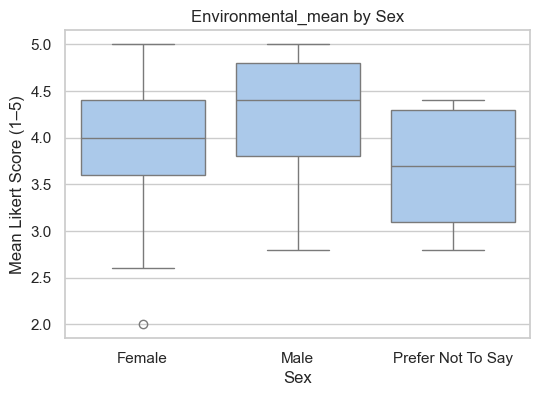

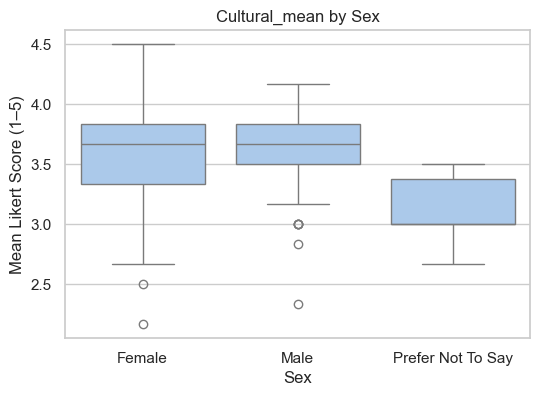

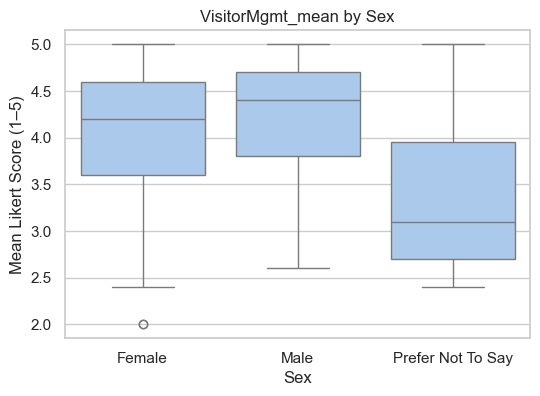

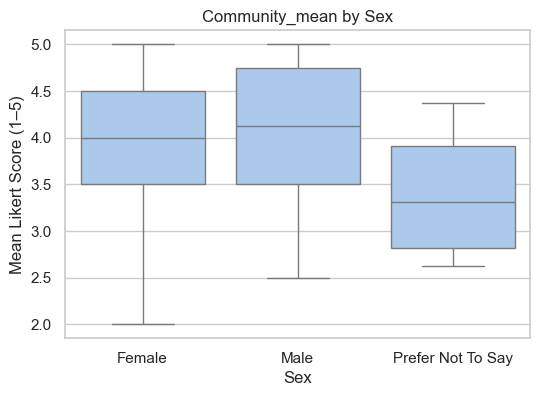

In [3]:
# =====================================================
# Sex-based statistical analysis for Paco Park study
# Using cleaned_numeric_data.xlsx
# =====================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_excel("cleaned_numeric_data.xlsx")

# Identify domain columns
domain_cols = [c for c in df.columns if "_mean" in c]
sex_col = [c for c in df.columns if "Sex" in c or "sex" in c]
sex_col = sex_col[0] if len(sex_col) > 0 else None

if not sex_col:
    print("⚠️ No column named 'Sex' found. Please check your dataset headers.")
else:
    # Clean up sex column values
    df["Sex_clean"] = df[sex_col].astype(str).str.strip().str.title()
    print(f"✅ Sex variable detected: {sex_col}")
    print("\n📋 Sex Frequency Table:")
    sex_counts = df["Sex_clean"].value_counts(dropna=False)
    sex_percent = df["Sex_clean"].value_counts(normalize=True) * 100
    display(pd.DataFrame({"Count": sex_counts, "Percent": sex_percent.round(2)}))

    # Compute descriptive statistics by sex
    print("\n📊 Mean Domain Scores by Sex:")
    sex_means = df.groupby("Sex_clean")[domain_cols].agg(["mean", "std", "count"])
    display(sex_means)

    # Statistical Tests: t-test (or Mann–Whitney if non-normal)
    print("\n🔬 Independent Tests by Sex:")
    results = []
    sexes = df["Sex_clean"].unique()
    if len(sexes) < 2:
        print("⚠️ Only one sex group found — no comparison possible.")
    else:
        g1, g2 = sexes[0], sexes[1]
        for col in domain_cols:
            group1 = df.loc[df["Sex_clean"] == g1, col].dropna()
            group2 = df.loc[df["Sex_clean"] == g2, col].dropna()

            # Test normality
            normal1 = stats.shapiro(group1)[1] > 0.05 if len(group1) >= 3 else False
            normal2 = stats.shapiro(group2)[1] > 0.05 if len(group2) >= 3 else False

            if normal1 and normal2:
                # Use independent t-test
                tstat, p = stats.ttest_ind(group1, group2, equal_var=False)
                test_used = "t-test"
            else:
                # Use nonparametric Mann-Whitney U test
                tstat, p = stats.mannwhitneyu(group1, group2, alternative="two-sided")
                test_used = "Mann–Whitney U"

            results.append({
                "Domain": col,
                "Test": test_used,
                f"Mean_{g1}": group1.mean(),
                f"Mean_{g2}": group2.mean(),
                "p-value": p
            })

        results_df = pd.DataFrame(results)
        results_df["Significant (α=0.05)"] = results_df["p-value"] < 0.05
        display(results_df)

    # Visualization
    print("\n🎨 Boxplots by Sex for Each Domain:")
    sns.set(style="whitegrid", palette="pastel")
    for col in domain_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x="Sex_clean", y=col)
        plt.title(f"{col} by Sex")
        plt.ylabel("Mean Likert Score (1–5)")
        plt.xlabel("Sex")
        plt.show()


📋 Sex Frequency Table:


,Sex,Count,Percent
0,Female,123,56.944444
1,Male,87,40.277778
2,Prefer Not To Say,6,2.777778


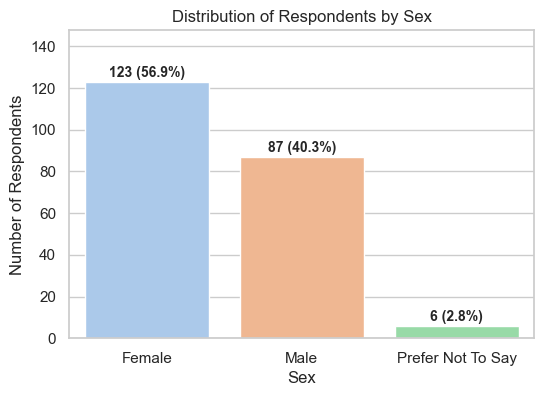

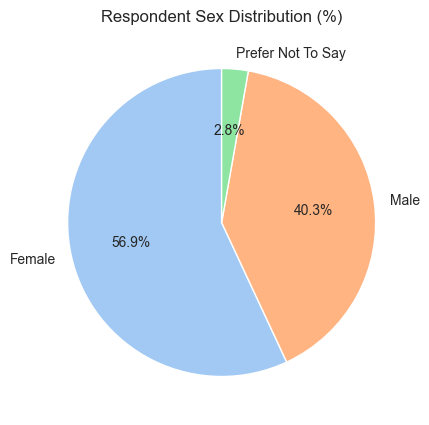

In [4]:
# =====================================================
# Visualization of Respondent Sex Distribution
# Using cleaned_numeric_data.xlsx
# =====================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel("cleaned_numeric_data.xlsx")

# Identify the Sex column
sex_col = [c for c in df.columns if "Sex" in c or "sex" in c]
if len(sex_col) == 0:
    print("⚠️ No column containing 'Sex' found. Please check your dataset headers.")
else:
    sex_col = sex_col[0]
    df["Sex_clean"] = df[sex_col].astype(str).str.strip().str.title()
    
    # Frequency and percentage
    freq_table = df["Sex_clean"].value_counts().reset_index()
    freq_table.columns = ["Sex", "Count"]
    freq_table["Percent"] = (freq_table["Count"] / freq_table["Count"].sum()) * 100
    
    print("📋 Sex Frequency Table:")
    display(freq_table)

    # Set Seaborn style
    sns.set(style="whitegrid", palette="pastel")

    # -------------------------------
    # 1️⃣ Bar Chart of Respondent Sex
    # -------------------------------
    plt.figure(figsize=(6,4))
    ax = sns.barplot(data=freq_table, x="Sex", y="Count", hue="Sex", dodge=False, legend=False)
    for i, row in freq_table.iterrows():
        ax.text(i, row["Count"] + 1, f"{row['Count']} ({row['Percent']:.1f}%)", 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.title("Distribution of Respondents by Sex")
    plt.ylabel("Number of Respondents")
    plt.xlabel("Sex")
    plt.ylim(0, freq_table["Count"].max() * 1.2)
    plt.show()

    # -------------------------------
    # 2️⃣ Pie Chart of Respondent Sex
    # -------------------------------
    colors = sns.color_palette("pastel")[:len(freq_table)]
    plt.figure(figsize=(5,5))
    plt.pie(freq_table["Count"], labels=freq_table["Sex"], autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 10})
    plt.title("Respondent Sex Distribution (%)")
    plt.show()
